In [55]:
!pip3 install scikit-learn tqdm catboost optuna xgboost ipywidgets imblearn
# 모델을 위해 필요한 라이브러리 설치(우수 예시에만 있는 부분)

In [56]:
import pandas as pd
import sklearn
import numpy as np
import random
import os
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler

In [57]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed=42
seed_everything(seed) # Seed 고정

In [68]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [69]:
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx',
    'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""
    
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

        
def manage_label_encoding(df_train, df_test):
    tmp = len(df_train)
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    
    df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

    for col in label_columns:
        df_all[col] = label_encoding(df_all[col])
    
    for col in label_columns:  
        df_train[col] = df_all.iloc[: tmp][col]
        df_test[col] = df_all.iloc[tmp :][col]

    return df_train, df_test

def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',
        'being followed up': 'being followed up.',
        'less than 6 months': '3 months ~ 6 months',
        '3_months_~_6_months' : '3 months ~ 6 months'
    })

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    ]
    
    ###############################
    #detect special char and to lower
    for i in label_columns:
        df_all[i] = df_all[i].str.lower()
        df_all[i] = df_all[i].str.replace(pat=r'[^\w]', repl=r'', regex=True)
        
    #to int
    df_all['id_strategic_ver'] = df_all['id_strategic_ver'].astype('int64')
    df_all['it_strategic_ver'] = df_all['it_strategic_ver'].astype('int64')
    df_all['idit_strategic_ver'] = df_all['idit_strategic_ver'].astype('int64')
    df_all['lead_desc_length'] = df_all['lead_desc_length'].astype('int64')
    df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].astype('int64')
    
    #seperate
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)
    
    #RobustScaler
    robustScaler = RobustScaler()
    df_train['ver_win_rate_x'] = robustScaler.fit_transform(df_train[['ver_win_rate_x']])
    df_test['ver_win_rate_x'] = robustScaler.transform(df_test[['ver_win_rate_x']])
    robustScaler = RobustScaler()
    df_train['ver_win_ratio_per_bu'] = robustScaler.fit_transform(df_train[['ver_win_ratio_per_bu']])
    df_test['ver_win_ratio_per_bu'] = robustScaler.transform(df_test[['ver_win_ratio_per_bu']])
    ##############################
    
    return df_train, df_test


df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)

In [70]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55780 entries, 0 to 55779
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   bant_submit              55780 non-null  float64 
 1   customer_country         55780 non-null  category
 2   business_unit            55780 non-null  category
 3   com_reg_ver_win_rate     55780 non-null  float64 
 4   customer_idx             55780 non-null  category
 5   customer_type            55780 non-null  category
 6   enterprise               55780 non-null  category
 7   historical_existing_cnt  55780 non-null  int64   
 8   id_strategic_ver         55780 non-null  category
 9   it_strategic_ver         55780 non-null  category
 10  idit_strategic_ver       55780 non-null  category
 11  customer_job             55780 non-null  category
 12  lead_desc_length         55780 non-null  int64   
 13  inquiry_type             55780 non-null  category
 14  product_cat

In [71]:
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
def custom_split(df_train, num=5, idx=0, smote=False, false_rate=1):
    global rate

    #shuffle
    true_df_train = sklearn.utils.shuffle(df_train[df_train["is_converted"]==True], random_state=seed)
    false_df_train = sklearn.utils.shuffle(df_train[df_train["is_converted"]==False], random_state=seed)
    
    #k-fold num
    slice_num = len(true_df_train) // num
    
    #True:False = 1:1
    tmp_train = pd.concat([true_df_train[0:slice_num*idx],
                           true_df_train[slice_num*(idx+1):],
                           false_df_train[0:int((slice_num*false_rate)*idx)],
                           false_df_train[int((slice_num*false_rate)*(idx+1)):]])
    tmp_val = pd.concat([true_df_train[slice_num*idx:slice_num*(idx+1)],
                         false_df_train[int((slice_num*false_rate)*idx):int((slice_num*false_rate)*(idx+1))]])
    #shuffle
    tmp_train = sklearn.utils.shuffle(tmp_train, random_state=seed)
    tmp_val = sklearn.utils.shuffle(tmp_val, random_state=seed)

    #split x and y
    x_train, y_train = tmp_train.drop("is_converted",axis=1), tmp_train["is_converted"]
    x_val, y_val = tmp_val.drop("is_converted",axis=1), tmp_val["is_converted"]
    
    if(smote):
        sm = BorderlineSMOTE(random_state=seed)
        x_train, y_train = sm.fit_resample(x_train, y_train)
    categorical_features = label_columns = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                             'customer_idx',
                                             'lead_owner',
                                            'id_strategic_ver',
                                            'it_strategic_ver',
                                            'idit_strategic_ver',
                                            'ver_cus',
                                            'ver_pro',
                                        ]
    train_pool = Pool(data=x_train, label=y_train, cat_features=categorical_features)
    val_pool = Pool(data=x_val, label=y_val, cat_features=categorical_features)

    return train_pool, val_pool, list(y_val)


all_train_pool = []
all_val_pool = []
all_y_val = []
k_fold_num = 10
for idx in range(k_fold_num):
    bundle = custom_split(df_train, num=k_fold_num, idx=idx, smote=False, false_rate=rate)
    all_train_pool.append(bundle[0])
    all_val_pool.append(bundle[1])
    all_y_val.append(bundle[2])

In [72]:
def objective(trial):
    params = {
        'iterations':trial.suggest_int("iterations", 1000, 30000),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.001, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-8,100),
        'random_strength': trial.suggest_uniform('random_strength',0,100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,100),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'verbose':False,
        'random_state':seed,
    }
    
    score = []
    tmp_score = []
    for train_pool, val_pool, y_true in zip(all_train_pool, all_val_pool, all_y_val):
        clf = CatBoostClassifier(**params,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                 task_type="GPU",
                                 devices='0',
                                early_stopping_rounds=100, 
                                )
        clf.fit(train_pool, eval_set=val_pool)
        
        y_pred = clf.predict(val_pool)
        y_pred = [False if i=='False' else True for i in y_pred]
        tmp_score.append(f1_score(y_true,y_pred,labels=[True, False]))
        score.append((f1_score(y_true,y_pred,labels=[True, False])+recall_score(y_true,y_pred))/2)
    score = np.mean(score)
    print(np.mean(tmp_score))
    return score

# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=None)

[I 2024-02-09 21:26:28,238] A new study created in memory with name: no-name-5f8f8d63-dec2-44ee-8960-51dd8b7b56f4
[I 2024-02-09 21:26:47,203] Trial 0 finished with value: 0.8534005463415113 and parameters: {'iterations': 11862, 'learning_rate': 0.9507635921035062, 'reg_lambda': 73.19939418382057, 'random_strength': 59.86584841970366, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.017073967431528128}. Best is trial 0 with value: 0.8534005463415113.


0.7548530407349705


[I 2024-02-09 21:27:16,105] Trial 1 finished with value: 0.8622983125789663 and parameters: {'iterations': 26119, 'learning_rate': 0.6015138967314656, 'reg_lambda': 70.80725778252382, 'random_strength': 2.0584494295802447, 'min_data_in_leaf': 97, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.07068974950624607}. Best is trial 1 with value: 0.8622983125789663.


0.7769775775388847


[I 2024-02-09 21:27:50,920] Trial 2 finished with value: 0.8469498271099468 and parameters: {'iterations': 6273, 'learning_rate': 0.18422110534358038, 'reg_lambda': 30.42422430291135, 'random_strength': 52.475643163223786, 'min_data_in_leaf': 44, 'leaf_estimation_iterations': 5, 'bagging_temperature': 2.801635158716261}. Best is trial 1 with value: 0.8622983125789663.


0.7469299572501968


[I 2024-02-09 21:28:18,898] Trial 3 finished with value: 0.8589591251040677 and parameters: {'iterations': 5045, 'learning_rate': 0.29285250388668294, 'reg_lambda': 36.63618433570556, 'random_strength': 45.606998421703594, 'min_data_in_leaf': 79, 'leaf_estimation_iterations': 3, 'bagging_temperature': 1.1400863701127328}. Best is trial 1 with value: 0.8622983125789663.


0.7670524493423342


[I 2024-02-09 21:28:29,793] Trial 4 finished with value: 0.7109518671966885 and parameters: {'iterations': 18180, 'learning_rate': 0.047403962307277725, 'reg_lambda': 60.754485194068394, 'random_strength': 17.052412368729154, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 15, 'bagging_temperature': 72.86653737491046}. Best is trial 1 with value: 0.8622983125789663.


0.7584838209734636


[I 2024-02-09 21:28:55,207] Trial 5 finished with value: 0.856888048240054 and parameters: {'iterations': 24444, 'learning_rate': 0.30530915540419734, 'reg_lambda': 9.767211409661668, 'random_strength': 68.42330265121569, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 2, 'bagging_temperature': 0.9565499215943827}. Best is trial 1 with value: 0.8622983125789663.


0.7655076982117096


[I 2024-02-09 21:29:15,884] Trial 6 finished with value: 0.8433351565229874 and parameters: {'iterations': 1997, 'learning_rate': 0.9094110816767033, 'reg_lambda': 25.877998167413896, 'random_strength': 66.2522284353982, 'min_data_in_leaf': 32, 'leaf_estimation_iterations': 8, 'bagging_temperature': 1.5375920235481764}. Best is trial 1 with value: 0.8622983125789663.


0.748791525167187


[I 2024-02-09 21:29:26,099] Trial 7 finished with value: 0.7109518671966885 and parameters: {'iterations': 6360, 'learning_rate': 0.969615043136794, 'reg_lambda': 77.51328233836013, 'random_strength': 93.9498941564189, 'min_data_in_leaf': 90, 'leaf_estimation_iterations': 9, 'bagging_temperature': 48.696409415209004}. Best is trial 1 with value: 0.8622983125789663.


0.7584838209734636


[I 2024-02-09 21:30:14,688] Trial 8 finished with value: 0.7593525220911961 and parameters: {'iterations': 3566, 'learning_rate': 0.19678687955672605, 'reg_lambda': 4.522728900601534, 'random_strength': 32.53303307632643, 'min_data_in_leaf': 39, 'leaf_estimation_iterations': 5, 'bagging_temperature': 20.651425578959262}. Best is trial 1 with value: 0.8622983125789663.


0.6161076415849893


[I 2024-02-09 21:30:24,506] Trial 9 finished with value: 0.7109518671966885 and parameters: {'iterations': 11346, 'learning_rate': 0.2816535751776934, 'reg_lambda': 54.26960832039789, 'random_strength': 14.092422497476264, 'min_data_in_leaf': 81, 'leaf_estimation_iterations': 2, 'bagging_temperature': 88.62326508576255}. Best is trial 1 with value: 0.8622983125789663.


0.7584838209734636


[I 2024-02-09 21:30:51,558] Trial 10 finished with value: 0.8598057355024846 and parameters: {'iterations': 29387, 'learning_rate': 0.6556785267510751, 'reg_lambda': 96.95371107909124, 'random_strength': 1.7961875614819434, 'min_data_in_leaf': 65, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.021064468501944014}. Best is trial 1 with value: 0.8622983125789663.


0.7711266225201205


[I 2024-02-09 21:31:18,050] Trial 11 finished with value: 0.8559314876195341 and parameters: {'iterations': 29432, 'learning_rate': 0.6272567612616611, 'reg_lambda': 99.74654747662224, 'random_strength': 0.8747366968610667, 'min_data_in_leaf': 67, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.01875348045209675}. Best is trial 1 with value: 0.8622983125789663.


0.7631616765377695


[I 2024-02-09 21:31:45,015] Trial 12 finished with value: 0.8581268611870343 and parameters: {'iterations': 29820, 'learning_rate': 0.6277679970235266, 'reg_lambda': 99.45420872881476, 'random_strength': 0.43462278479123495, 'min_data_in_leaf': 63, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.09470314305954813}. Best is trial 1 with value: 0.8622983125789663.


0.7666866228069691


[I 2024-02-09 21:32:10,039] Trial 13 finished with value: 0.8569388305304386 and parameters: {'iterations': 22947, 'learning_rate': 0.6923736143258277, 'reg_lambda': 80.9773397051379, 'random_strength': 26.146514454869475, 'min_data_in_leaf': 99, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.08101324842116016}. Best is trial 1 with value: 0.8622983125789663.


0.7688560160392323


[I 2024-02-09 21:32:35,243] Trial 14 finished with value: 0.8585965141034423 and parameters: {'iterations': 24212, 'learning_rate': 0.4680293148649111, 'reg_lambda': 87.17031008883396, 'random_strength': 12.870997019648975, 'min_data_in_leaf': 62, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.11516744025981103}. Best is trial 1 with value: 0.8622983125789663.


0.765461426475283


[I 2024-02-09 21:33:00,710] Trial 15 finished with value: 0.8552795957706003 and parameters: {'iterations': 19696, 'learning_rate': 0.7647770038281734, 'reg_lambda': 63.634222628284014, 'random_strength': 34.92963122689709, 'min_data_in_leaf': 100, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.25327114788599464}. Best is trial 1 with value: 0.8622983125789663.


0.7685678495498588


[I 2024-02-09 21:33:27,913] Trial 16 finished with value: 0.8588224601241397 and parameters: {'iterations': 26731, 'learning_rate': 0.4739655146776491, 'reg_lambda': 88.05713128791625, 'random_strength': 85.73911300093486, 'min_data_in_leaf': 79, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.011065136021090997}. Best is trial 1 with value: 0.8622983125789663.


0.7674284700318291


[I 2024-02-09 21:33:52,334] Trial 17 finished with value: 0.8572070671146088 and parameters: {'iterations': 19996, 'learning_rate': 0.7963976000342017, 'reg_lambda': 46.416649609853486, 'random_strength': 7.018847425761147, 'min_data_in_leaf': 57, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.038578655738148664}. Best is trial 1 with value: 0.8622983125789663.


0.7724227922378757


[I 2024-02-09 21:34:18,620] Trial 18 finished with value: 0.8554099286003451 and parameters: {'iterations': 26880, 'learning_rate': 0.5558050716155853, 'reg_lambda': 66.87918727852504, 'random_strength': 21.263036293030744, 'min_data_in_leaf': 73, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.29823400101962777}. Best is trial 1 with value: 0.8622983125789663.


0.7666640130448463


[I 2024-02-09 21:34:47,355] Trial 19 finished with value: 0.8622397553892369 and parameters: {'iterations': 21979, 'learning_rate': 0.4208939005131713, 'reg_lambda': 90.7705661422377, 'random_strength': 32.01560045100456, 'min_data_in_leaf': 27, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.0453129298652518}. Best is trial 1 with value: 0.8622983125789663.


0.7733972596962229


[I 2024-02-09 21:35:18,478] Trial 20 finished with value: 0.8629747468090629 and parameters: {'iterations': 15257, 'learning_rate': 0.40548311062258774, 'reg_lambda': 87.42317790677313, 'random_strength': 36.06791970055565, 'min_data_in_leaf': 24, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.3546395061909741}. Best is trial 20 with value: 0.8629747468090629.


0.7778975455661777


[I 2024-02-09 21:35:48,135] Trial 21 finished with value: 0.8614066425270659 and parameters: {'iterations': 14850, 'learning_rate': 0.4042311481152849, 'reg_lambda': 87.56509453832098, 'random_strength': 41.94405354308335, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.28547622963343294}. Best is trial 20 with value: 0.8629747468090629.


0.7767093889502358


[I 2024-02-09 21:36:13,127] Trial 22 finished with value: 0.858630957208956 and parameters: {'iterations': 16356, 'learning_rate': 0.4106282667469586, 'reg_lambda': 71.88250774994415, 'random_strength': 35.90533654674879, 'min_data_in_leaf': 28, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.07023338285185876}. Best is trial 20 with value: 0.8629747468090629.


0.7668290139850112


[I 2024-02-09 21:36:40,214] Trial 23 finished with value: 0.8612639689400685 and parameters: {'iterations': 21679, 'learning_rate': 0.5459361553349446, 'reg_lambda': 82.96563357063496, 'random_strength': 24.198585284637815, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.5802607846571057}. Best is trial 20 with value: 0.8629747468090629.


0.7746924400446393


[I 2024-02-09 21:37:10,758] Trial 24 finished with value: 0.8302706439273525 and parameters: {'iterations': 13441, 'learning_rate': 0.38215257439038874, 'reg_lambda': 49.629685339591376, 'random_strength': 50.49425591719064, 'min_data_in_leaf': 52, 'leaf_estimation_iterations': 7, 'bagging_temperature': 7.49821921559553}. Best is trial 20 with value: 0.8629747468090629.


0.7213637986772155


[I 2024-02-09 21:37:57,944] Trial 25 finished with value: 0.8581096749491163 and parameters: {'iterations': 16853, 'learning_rate': 0.13029907111311306, 'reg_lambda': 93.31352874822011, 'random_strength': 30.184405219660736, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.04160151857819404}. Best is trial 20 with value: 0.8629747468090629.


0.7599422936211766


[I 2024-02-09 21:38:24,444] Trial 26 finished with value: 0.8604668902653744 and parameters: {'iterations': 9144, 'learning_rate': 0.5419009125203709, 'reg_lambda': 73.12661737159812, 'random_strength': 78.63088289449561, 'min_data_in_leaf': 35, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.19181090239094006}. Best is trial 20 with value: 0.8629747468090629.


0.7767779363749047


[I 2024-02-09 21:38:54,011] Trial 27 finished with value: 0.8603826023699975 and parameters: {'iterations': 20860, 'learning_rate': 0.3502505072865397, 'reg_lambda': 91.6083330745151, 'random_strength': 39.09802262416011, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.038708111164052796}. Best is trial 20 with value: 0.8629747468090629.


0.7703323043070947


[I 2024-02-09 21:39:17,470] Trial 28 finished with value: 0.8531918744742196 and parameters: {'iterations': 26567, 'learning_rate': 0.729560693292319, 'reg_lambda': 59.5014256193673, 'random_strength': 12.818117555813402, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.5457752128168506}. Best is trial 20 with value: 0.8629747468090629.


0.7615785541432445


[I 2024-02-09 21:39:39,750] Trial 29 finished with value: 0.8525937542780824 and parameters: {'iterations': 11477, 'learning_rate': 0.8919643459053194, 'reg_lambda': 70.29337879117867, 'random_strength': 50.77907881571601, 'min_data_in_leaf': 21, 'leaf_estimation_iterations': 4, 'bagging_temperature': 0.1504690037667668}. Best is trial 20 with value: 0.8629747468090629.


0.7597329631016194


[I 2024-02-09 21:40:08,424] Trial 30 finished with value: 0.8435845931257105 and parameters: {'iterations': 17747, 'learning_rate': 0.47858411727087924, 'reg_lambda': 75.17354901690396, 'random_strength': 59.53346017979044, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 6, 'bagging_temperature': 4.273918442127831}. Best is trial 20 with value: 0.8629747468090629.


0.7438791429613778


[I 2024-02-09 21:40:35,548] Trial 31 finished with value: 0.8579652272834078 and parameters: {'iterations': 13627, 'learning_rate': 0.41522514713350955, 'reg_lambda': 84.73242346604232, 'random_strength': 43.88880954951587, 'min_data_in_leaf': 21, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.40115568418946457}. Best is trial 20 with value: 0.8629747468090629.


0.7670127056490668


[I 2024-02-09 21:41:12,707] Trial 32 finished with value: 0.8638901905361005 and parameters: {'iterations': 14389, 'learning_rate': 0.22911490989166083, 'reg_lambda': 90.19255830707804, 'random_strength': 41.31359170698337, 'min_data_in_leaf': 25, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.05899892590774484}. Best is trial 32 with value: 0.8638901905361005.


0.7743171776089974


[I 2024-02-09 21:41:47,511] Trial 33 finished with value: 0.8595139859896289 and parameters: {'iterations': 9178, 'learning_rate': 0.20252275351315527, 'reg_lambda': 79.91902568616408, 'random_strength': 56.21404229718286, 'min_data_in_leaf': 44, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.05300891231266084}. Best is trial 32 with value: 0.8638901905361005.


0.764049617000903


[I 2024-02-09 21:43:14,424] Trial 34 finished with value: 0.8408326922856789 and parameters: {'iterations': 18745, 'learning_rate': 0.02007897280311724, 'reg_lambda': 93.447814515809, 'random_strength': 45.583506691459306, 'min_data_in_leaf': 38, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.016460490546713603}. Best is trial 32 with value: 0.8638901905361005.


0.730583133489107


[I 2024-02-09 21:44:01,624] Trial 35 finished with value: 0.8548595996733568 and parameters: {'iterations': 14261, 'learning_rate': 0.11141896811722979, 'reg_lambda': 91.2055129704726, 'random_strength': 29.803054354876743, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 4, 'bagging_temperature': 0.024292914692040538}. Best is trial 32 with value: 0.8638901905361005.


0.7553901950177091


[I 2024-02-09 21:44:32,463] Trial 36 finished with value: 0.8626552718123618 and parameters: {'iterations': 22215, 'learning_rate': 0.26428841844960316, 'reg_lambda': 42.59475776469466, 'random_strength': 67.29126690000582, 'min_data_in_leaf': 27, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.16994733463771944}. Best is trial 32 with value: 0.8638901905361005.


0.7750940934082732


[I 2024-02-09 21:45:02,514] Trial 37 finished with value: 0.8557697029670788 and parameters: {'iterations': 24583, 'learning_rate': 0.2637643853550562, 'reg_lambda': 40.321830788413465, 'random_strength': 68.87545518272614, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 6, 'bagging_temperature': 1.6985584206519828}. Best is trial 32 with value: 0.8638901905361005.


0.7639203583151098


[I 2024-02-09 21:45:27,954] Trial 38 finished with value: 0.8580063299551484 and parameters: {'iterations': 9352, 'learning_rate': 0.32225481348809426, 'reg_lambda': 22.334037212180295, 'random_strength': 76.20684202371277, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.7573340500265165}. Best is trial 32 with value: 0.8638901905361005.


0.767311361208998


[I 2024-02-09 21:46:10,178] Trial 39 finished with value: 0.8608781178348759 and parameters: {'iterations': 15559, 'learning_rate': 0.24039798873197643, 'reg_lambda': 37.32878952292243, 'random_strength': 64.07295339504434, 'min_data_in_leaf': 41, 'leaf_estimation_iterations': 1, 'bagging_temperature': 0.15061072491024552}. Best is trial 32 with value: 0.8638901905361005.


0.7672107811242972


[I 2024-02-09 21:46:53,444] Trial 40 finished with value: 0.8485016261230232 and parameters: {'iterations': 18575, 'learning_rate': 0.09675099528890027, 'reg_lambda': 32.153912688169825, 'random_strength': 74.49855109680118, 'min_data_in_leaf': 87, 'leaf_estimation_iterations': 4, 'bagging_temperature': 2.2297159364709533}. Best is trial 32 with value: 0.8638901905361005.


0.746353901596696


[I 2024-02-09 21:47:22,222] Trial 41 finished with value: 0.8602549772043186 and parameters: {'iterations': 22358, 'learning_rate': 0.34008940717007974, 'reg_lambda': 57.274331215785, 'random_strength': 56.74545119531111, 'min_data_in_leaf': 28, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.06030865899094697}. Best is trial 32 with value: 0.8638901905361005.


0.7711593050579881


[I 2024-02-09 21:47:58,347] Trial 42 finished with value: 0.8629537431884786 and parameters: {'iterations': 25035, 'learning_rate': 0.23058010321879382, 'reg_lambda': 44.18799351443478, 'random_strength': 20.604611784919136, 'min_data_in_leaf': 32, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.03273270650503796}. Best is trial 32 with value: 0.8638901905361005.


0.772660733130204


[I 2024-02-09 21:48:37,696] Trial 43 finished with value: 0.8607641925053905 and parameters: {'iterations': 28171, 'learning_rate': 0.18140937603446736, 'reg_lambda': 44.25157473044117, 'random_strength': 22.30911713132144, 'min_data_in_leaf': 35, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.11586732287289228}. Best is trial 32 with value: 0.8638901905361005.


0.7704461339285299


[I 2024-02-09 21:49:16,540] Trial 44 finished with value: 0.8600946118143465 and parameters: {'iterations': 25557, 'learning_rate': 0.15981540711610176, 'reg_lambda': 50.846036548880626, 'random_strength': 8.644355574163402, 'min_data_in_leaf': 21, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.01041751597547084}. Best is trial 32 with value: 0.8638901905361005.


0.7645615180009875


[I 2024-02-09 21:49:52,680] Trial 45 finished with value: 0.8640383192239858 and parameters: {'iterations': 23277, 'learning_rate': 0.218789734948098, 'reg_lambda': 22.666482896305016, 'random_strength': 39.23364078137274, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.025166774179517397}. Best is trial 45 with value: 0.8640383192239858.


0.7772108375821705


[I 2024-02-09 21:50:21,833] Trial 46 finished with value: 0.8585608141880476 and parameters: {'iterations': 23943, 'learning_rate': 0.2350595751103216, 'reg_lambda': 19.724746949628717, 'random_strength': 40.56725281547213, 'min_data_in_leaf': 34, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.026859354871970584}. Best is trial 45 with value: 0.8640383192239858.


0.7669051781596449


[I 2024-02-09 21:50:49,370] Trial 47 finished with value: 0.8637924859830143 and parameters: {'iterations': 12574, 'learning_rate': 0.2973823939319693, 'reg_lambda': 12.857207017255682, 'random_strength': 47.93334265469677, 'min_data_in_leaf': 24, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.027735854454739178}. Best is trial 45 with value: 0.8640383192239858.


0.7778014221824792


[I 2024-02-09 21:51:37,672] Trial 48 finished with value: 0.859393110081152 and parameters: {'iterations': 12498, 'learning_rate': 0.09026423419657725, 'reg_lambda': 12.501588553545167, 'random_strength': 17.763982518929325, 'min_data_in_leaf': 24, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.014022193409097371}. Best is trial 45 with value: 0.8640383192239858.


0.7651065664826502


[I 2024-02-09 21:52:32,617] Trial 49 finished with value: 0.8610552598920403 and parameters: {'iterations': 6520, 'learning_rate': 0.05909025951332153, 'reg_lambda': 2.665036982307342, 'random_strength': 47.68651440047964, 'min_data_in_leaf': 51, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.027925157423408637}. Best is trial 45 with value: 0.8640383192239858.


0.768647316320877


[I 2024-02-09 21:52:58,930] Trial 50 finished with value: 0.8595432375604357 and parameters: {'iterations': 12615, 'learning_rate': 0.3070133209650643, 'reg_lambda': 11.95690720492967, 'random_strength': 38.028418964438096, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.030710651279847838}. Best is trial 45 with value: 0.8640383192239858.


0.7710345270689235


[I 2024-02-09 21:53:30,319] Trial 51 finished with value: 0.8635889362561684 and parameters: {'iterations': 10190, 'learning_rate': 0.2330840318078999, 'reg_lambda': 30.2484007295968, 'random_strength': 46.781802199197, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.08571488719430226}. Best is trial 45 with value: 0.8640383192239858.


0.7763120716465359


[I 2024-02-09 21:54:04,835] Trial 52 finished with value: 0.8630390398474326 and parameters: {'iterations': 10544, 'learning_rate': 0.2213327143859734, 'reg_lambda': 27.926747755342397, 'random_strength': 52.95726527134407, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.07160651526596903}. Best is trial 45 with value: 0.8640383192239858.


0.7732642268810124


[I 2024-02-09 21:54:47,329] Trial 53 finished with value: 0.8652158381450585 and parameters: {'iterations': 7653, 'learning_rate': 0.15077778581519943, 'reg_lambda': 28.802384076028538, 'random_strength': 54.46142857957114, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.06804956593340444}. Best is trial 53 with value: 0.8652158381450585.


0.7797823256407664


[I 2024-02-09 21:55:21,631] Trial 54 finished with value: 0.8590210155145283 and parameters: {'iterations': 7972, 'learning_rate': 0.14662135337364238, 'reg_lambda': 26.655790213780513, 'random_strength': 54.559820011097926, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.07581406498476287}. Best is trial 53 with value: 0.8652158381450585.


0.7645788275658528


[I 2024-02-09 21:55:58,717] Trial 55 finished with value: 0.8655517158527593 and parameters: {'iterations': 4629, 'learning_rate': 0.1973970354696571, 'reg_lambda': 16.342952429147473, 'random_strength': 47.566061941140326, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.10419814826667267}. Best is trial 55 with value: 0.8655517158527593.


0.7795882801903671


[I 2024-02-09 21:56:39,199] Trial 56 finished with value: 0.8665732224564386 and parameters: {'iterations': 4148, 'learning_rate': 0.17658593817917556, 'reg_lambda': 16.597845991426073, 'random_strength': 46.7804214059977, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.10339549023630411}. Best is trial 56 with value: 0.8665732224564386.


0.7820641938306264


[I 2024-02-09 21:57:14,792] Trial 57 finished with value: 0.8637090953109384 and parameters: {'iterations': 2849, 'learning_rate': 0.17669434399429532, 'reg_lambda': 17.86228896913225, 'random_strength': 61.701803616350304, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.01836773297915762}. Best is trial 56 with value: 0.8665732224564386.


0.7733056365093227


[I 2024-02-09 21:57:44,132] Trial 58 finished with value: 0.8624039033214336 and parameters: {'iterations': 4616, 'learning_rate': 0.27978380567941824, 'reg_lambda': 7.93470470839606, 'random_strength': 42.400738355206876, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.1023446769683248}. Best is trial 56 with value: 0.8665732224564386.


0.7752407070757674


[I 2024-02-09 21:58:42,136] Trial 59 finished with value: 0.8574371585697527 and parameters: {'iterations': 1779, 'learning_rate': 0.06472212373546352, 'reg_lambda': 15.279234812943516, 'random_strength': 49.35627959094585, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.049655335862866155}. Best is trial 56 with value: 0.8665732224564386.


0.7609782132434013


[I 2024-02-09 21:58:54,089] Trial 60 finished with value: 0.7116420355304912 and parameters: {'iterations': 5599, 'learning_rate': 0.010876913299184804, 'reg_lambda': 5.938778495819693, 'random_strength': 59.48363319985726, 'min_data_in_leaf': 25, 'leaf_estimation_iterations': 12, 'bagging_temperature': 38.40259892013036}. Best is trial 56 with value: 0.8665732224564386.


0.7598641576410692


[I 2024-02-09 21:59:28,432] Trial 61 finished with value: 0.8637521975769958 and parameters: {'iterations': 3253, 'learning_rate': 0.18078782411839114, 'reg_lambda': 19.228245793240788, 'random_strength': 61.66571850806876, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.019423722644469538}. Best is trial 56 with value: 0.8665732224564386.


0.774041191690788


[I 2024-02-09 22:00:14,457] Trial 62 finished with value: 0.8621939327574133 and parameters: {'iterations': 3784, 'learning_rate': 0.1261964366137429, 'reg_lambda': 21.6863621661579, 'random_strength': 47.94316658048883, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.014062822393785243}. Best is trial 56 with value: 0.8665732224564386.


0.7724398135667745


[I 2024-02-09 22:00:52,438] Trial 63 finished with value: 0.867784919501321 and parameters: {'iterations': 1102, 'learning_rate': 0.19620991002335686, 'reg_lambda': 16.356838312507666, 'random_strength': 53.13962270936217, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.21927171189227082}. Best is trial 63 with value: 0.867784919501321.


0.7847040381368411


[I 2024-02-09 22:01:30,596] Trial 64 finished with value: 0.8623782973743364 and parameters: {'iterations': 1272, 'learning_rate': 0.15221103355675702, 'reg_lambda': 15.108410108876253, 'random_strength': 52.248239888715716, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.19494919568646255}. Best is trial 63 with value: 0.867784919501321.


0.7743236943157723


[I 2024-02-09 22:02:00,012] Trial 65 finished with value: 0.8626994898816461 and parameters: {'iterations': 7193, 'learning_rate': 0.36710275020948735, 'reg_lambda': 23.793376182266208, 'random_strength': 34.90795906912739, 'min_data_in_leaf': 21, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.10954649941752798}. Best is trial 63 with value: 0.867784919501321.


0.7795115338758464


[I 2024-02-09 22:02:37,606] Trial 66 finished with value: 0.8643581166323442 and parameters: {'iterations': 4484, 'learning_rate': 0.20141587563594496, 'reg_lambda': 11.368934969739506, 'random_strength': 43.5805344699924, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.2346285019533901}. Best is trial 63 with value: 0.867784919501321.


0.7793655839140389


[I 2024-02-09 22:03:18,831] Trial 67 finished with value: 0.8659276054966328 and parameters: {'iterations': 4278, 'learning_rate': 0.2071798301215062, 'reg_lambda': 35.161903835034224, 'random_strength': 39.43252065760747, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.3041833824956066}. Best is trial 63 with value: 0.867784919501321.


0.7835868127248673


[I 2024-02-09 22:04:21,709] Trial 68 finished with value: 0.8617837497483434 and parameters: {'iterations': 4227, 'learning_rate': 0.07865004559959915, 'reg_lambda': 31.840310554667973, 'random_strength': 44.44228638527332, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.23397990199951016}. Best is trial 63 with value: 0.867784919501321.


0.7711865471157345


[I 2024-02-09 22:05:01,749] Trial 69 finished with value: 0.8656819314625125 and parameters: {'iterations': 5264, 'learning_rate': 0.19322177036857457, 'reg_lambda': 35.315673404302096, 'random_strength': 28.936674982009748, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.4743647434569518}. Best is trial 63 with value: 0.867784919501321.


0.7809309624921245


[I 2024-02-09 22:05:49,072] Trial 70 finished with value: 0.8612875716131952 and parameters: {'iterations': 2530, 'learning_rate': 0.12366368893245835, 'reg_lambda': 33.683693321060815, 'random_strength': 33.018835406723824, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.4186586053755818}. Best is trial 63 with value: 0.867784919501321.


0.7721422427934901


[I 2024-02-09 22:06:23,163] Trial 71 finished with value: 0.8592553625607092 and parameters: {'iterations': 5974, 'learning_rate': 0.20541794759808146, 'reg_lambda': 9.708384738303543, 'random_strength': 25.7454288220268, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.8416966571837966}. Best is trial 63 with value: 0.867784919501321.


0.7691600757707693


[I 2024-02-09 22:06:54,207] Trial 72 finished with value: 0.8599750026979128 and parameters: {'iterations': 4533, 'learning_rate': 0.2587016671579616, 'reg_lambda': 37.64464663222848, 'random_strength': 28.84923600417411, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.4693472258661055}. Best is trial 63 with value: 0.867784919501321.


0.7701664556122758


[I 2024-02-09 22:07:37,123] Trial 73 finished with value: 0.8653666946192438 and parameters: {'iterations': 5309, 'learning_rate': 0.20022133846217888, 'reg_lambda': 25.3851452448015, 'random_strength': 99.79032910021786, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.1304567063206843}. Best is trial 63 with value: 0.867784919501321.


0.7820320905371887


[I 2024-02-09 22:08:17,840] Trial 74 finished with value: 0.8613576639314703 and parameters: {'iterations': 5306, 'learning_rate': 0.16465162919990564, 'reg_lambda': 16.679719835404597, 'random_strength': 92.48908609078242, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.296304609100185}. Best is trial 63 with value: 0.867784919501321.


0.7724988776464904


[I 2024-02-09 22:09:40,686] Trial 75 finished with value: 0.8561723148670242 and parameters: {'iterations': 6959, 'learning_rate': 0.04157700060602465, 'reg_lambda': 28.76952947201331, 'random_strength': 97.91621785099164, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 12, 'bagging_temperature': 1.184344068128982}. Best is trial 63 with value: 0.867784919501321.


0.7590978764872951


[I 2024-02-09 22:10:20,595] Trial 76 finished with value: 0.8603064769391651 and parameters: {'iterations': 8016, 'learning_rate': 0.19366347944042905, 'reg_lambda': 35.05568602271772, 'random_strength': 85.32004394028621, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.6332294312057904}. Best is trial 63 with value: 0.867784919501321.


0.7736432569086329


[I 2024-02-09 22:11:01,419] Trial 77 finished with value: 0.8600901976361979 and parameters: {'iterations': 1210, 'learning_rate': 0.13353130561892645, 'reg_lambda': 24.328409282385238, 'random_strength': 36.986105812529885, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.2147743751838623}. Best is trial 63 with value: 0.867784919501321.


0.7675829926749931


[I 2024-02-09 22:11:51,764] Trial 78 finished with value: 0.8618298196807848 and parameters: {'iterations': 2207, 'learning_rate': 0.0973132456650318, 'reg_lambda': 26.09467442608335, 'random_strength': 44.7782093834636, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.13690475169560598}. Best is trial 63 with value: 0.867784919501321.


0.7714951371970674


[I 2024-02-09 22:12:22,462] Trial 79 finished with value: 0.8605715698144353 and parameters: {'iterations': 3728, 'learning_rate': 0.32695395833527896, 'reg_lambda': 39.93150904347594, 'random_strength': 71.69003436437856, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.3408037693212561}. Best is trial 63 with value: 0.867784919501321.


0.774606343092074


[I 2024-02-09 22:12:52,724] Trial 80 finished with value: 0.8581940195258172 and parameters: {'iterations': 5111, 'learning_rate': 0.19495518116206467, 'reg_lambda': 0.8714041686408098, 'random_strength': 57.533330007992234, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.13332348704943628}. Best is trial 63 with value: 0.867784919501321.


0.763141285804881


[I 2024-02-09 22:13:23,009] Trial 81 finished with value: 0.8614384124795768 and parameters: {'iterations': 7765, 'learning_rate': 0.2649368517676151, 'reg_lambda': 21.224092182798664, 'random_strength': 39.71117763672075, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.16897774619031228}. Best is trial 63 with value: 0.867784919501321.


0.7726603747427034


[I 2024-02-09 22:14:02,377] Trial 82 finished with value: 0.8630872355159159 and parameters: {'iterations': 2861, 'learning_rate': 0.15982500267243882, 'reg_lambda': 8.963331988346495, 'random_strength': 32.658275067862775, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.27574745013123436}. Best is trial 63 with value: 0.867784919501321.


0.7781225229798839


[I 2024-02-09 22:14:37,300] Trial 83 finished with value: 0.8621056238876219 and parameters: {'iterations': 4185, 'learning_rate': 0.21006546562497, 'reg_lambda': 14.0367990950091, 'random_strength': 42.48512520144536, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.22517937698947071}. Best is trial 63 with value: 0.867784919501321.


0.7742112477752441


[I 2024-02-09 22:15:11,015] Trial 84 finished with value: 0.8631042404073084 and parameters: {'iterations': 6229, 'learning_rate': 0.2546234887660581, 'reg_lambda': 17.56783613809744, 'random_strength': 50.85677294467534, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.09715178483630818}. Best is trial 63 with value: 0.867784919501321.


0.7777236323297683


[I 2024-02-09 22:16:04,846] Trial 85 finished with value: 0.8662326994969103 and parameters: {'iterations': 4922, 'learning_rate': 0.10855235466042502, 'reg_lambda': 24.50789957828966, 'random_strength': 54.55064049294063, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.4767852187534192}. Best is trial 63 with value: 0.867784919501321.


0.7787857453141668


[I 2024-02-09 22:17:26,999] Trial 86 finished with value: 0.8566620883231615 and parameters: {'iterations': 5153, 'learning_rate': 0.033762222844702955, 'reg_lambda': 5.539086353456683, 'random_strength': 54.81492445781929, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.5450086515411262}. Best is trial 63 with value: 0.867784919501321.


0.7587787221008684


[I 2024-02-09 22:18:10,172] Trial 87 finished with value: 0.8589901105225575 and parameters: {'iterations': 3521, 'learning_rate': 0.11247285018375229, 'reg_lambda': 30.05884175386879, 'random_strength': 27.35576831348532, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.3682386514687305}. Best is trial 63 with value: 0.867784919501321.


0.7651663682312625


[I 2024-02-09 22:18:55,155] Trial 88 finished with value: 0.8629476218664202 and parameters: {'iterations': 2116, 'learning_rate': 0.13974061074109273, 'reg_lambda': 11.19821888323429, 'random_strength': 65.35195398398693, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.7278929564203108}. Best is trial 63 with value: 0.867784919501321.


0.7771939450315419


[I 2024-02-09 22:19:24,136] Trial 89 finished with value: 0.8605038191870247 and parameters: {'iterations': 8634, 'learning_rate': 0.2900684732020046, 'reg_lambda': 19.280667615068147, 'random_strength': 52.36330645916019, 'min_data_in_leaf': 57, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.1272798237940685}. Best is trial 63 with value: 0.867784919501321.


0.7707911881575987


[I 2024-02-09 22:20:30,054] Trial 90 finished with value: 0.8609541184429762 and parameters: {'iterations': 5741, 'learning_rate': 0.06699632125469468, 'reg_lambda': 25.116009943452067, 'random_strength': 84.37527859535965, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.4799975073585257}. Best is trial 63 with value: 0.867784919501321.


0.7710424360201517


[I 2024-02-09 22:21:03,811] Trial 91 finished with value: 0.8630645990598775 and parameters: {'iterations': 6246, 'learning_rate': 0.2190839016219591, 'reg_lambda': 22.670299135241024, 'random_strength': 34.68784667361788, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.17479991719522622}. Best is trial 63 with value: 0.867784919501321.


0.7754798474704044


[I 2024-02-09 22:21:37,411] Trial 92 finished with value: 0.8554432419324414 and parameters: {'iterations': 7389, 'learning_rate': 0.1716800847461141, 'reg_lambda': 27.640753161100054, 'random_strength': 38.26809484593208, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 10, 'bagging_temperature': 1.0940148349475771}. Best is trial 63 with value: 0.867784919501321.


0.7602371332155322


[I 2024-02-09 22:22:15,217] Trial 93 finished with value: 0.8629050889638998 and parameters: {'iterations': 4662, 'learning_rate': 0.2070471404997708, 'reg_lambda': 32.299169878802175, 'random_strength': 45.75698545805065, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.06419538436587188}. Best is trial 63 with value: 0.867784919501321.


0.7762430783607


[I 2024-02-09 22:23:03,311] Trial 94 finished with value: 0.8627485477363364 and parameters: {'iterations': 3126, 'learning_rate': 0.10834253561442526, 'reg_lambda': 20.459565422339047, 'random_strength': 48.740075654830925, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.3245664005087889}. Best is trial 63 with value: 0.867784919501321.


0.775064195039772


[I 2024-02-09 22:23:33,846] Trial 95 finished with value: 0.8621899505049047 and parameters: {'iterations': 1858, 'learning_rate': 0.24067772819147196, 'reg_lambda': 15.556922615414933, 'random_strength': 42.989734954069576, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.09292772491326014}. Best is trial 63 with value: 0.867784919501321.


0.7739470005769091


[I 2024-02-09 22:24:09,632] Trial 96 finished with value: 0.8594364588359513 and parameters: {'iterations': 3775, 'learning_rate': 0.14832782427183872, 'reg_lambda': 23.875003976584644, 'random_strength': 40.33929791120524, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.2589014868552769}. Best is trial 63 with value: 0.867784919501321.


0.7654097142086991


[I 2024-02-09 22:24:47,942] Trial 97 finished with value: 0.8612587902620605 and parameters: {'iterations': 6763, 'learning_rate': 0.17952130108885098, 'reg_lambda': 34.2853862257295, 'random_strength': 31.370974393506913, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.046782899581049274}. Best is trial 63 with value: 0.867784919501321.


0.77121887922542


[I 2024-02-09 22:25:45,032] Trial 98 finished with value: 0.8614258828264907 and parameters: {'iterations': 4864, 'learning_rate': 0.08325441928682187, 'reg_lambda': 38.60757130040473, 'random_strength': 53.79057696184986, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.15323911648777125}. Best is trial 63 with value: 0.867784919501321.


0.7693885621897781


[I 2024-02-09 22:26:14,087] Trial 99 finished with value: 0.8599991712568602 and parameters: {'iterations': 1096, 'learning_rate': 0.28658354699969435, 'reg_lambda': 35.90881378884036, 'random_strength': 57.6954522472506, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.07702034367286759}. Best is trial 63 with value: 0.867784919501321.


0.7708641433795215


[I 2024-02-09 22:26:43,318] Trial 100 finished with value: 0.862357991451691 and parameters: {'iterations': 8471, 'learning_rate': 0.3140130962103557, 'reg_lambda': 7.398323588575856, 'random_strength': 81.44423987244758, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.20286324193802546}. Best is trial 63 with value: 0.867784919501321.


0.7801272383146374


[I 2024-02-09 22:27:15,324] Trial 101 finished with value: 0.8633366889109867 and parameters: {'iterations': 20111, 'learning_rate': 0.24158611955389026, 'reg_lambda': 17.638614089146753, 'random_strength': 41.41709245358108, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.05640046289762509}. Best is trial 63 with value: 0.867784919501321.


0.7764569276055233


[I 2024-02-09 22:27:47,975] Trial 102 finished with value: 0.8615069218367835 and parameters: {'iterations': 17001, 'learning_rate': 0.19581852160303945, 'reg_lambda': 11.019914050057299, 'random_strength': 45.97803232906262, 'min_data_in_leaf': 26, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.035040492275616175}. Best is trial 63 with value: 0.867784919501321.


0.7740960947558179


[I 2024-02-09 22:28:22,787] Trial 103 finished with value: 0.8644559414624478 and parameters: {'iterations': 5594, 'learning_rate': 0.21599045808106832, 'reg_lambda': 46.99520130397856, 'random_strength': 50.20256382547835, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.04042771992889527}. Best is trial 63 with value: 0.867784919501321.


0.7756651296781422


[I 2024-02-09 22:29:00,979] Trial 104 finished with value: 0.8608296582339218 and parameters: {'iterations': 5481, 'learning_rate': 0.15641195111485934, 'reg_lambda': 55.81500183539632, 'random_strength': 50.27112832788463, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.11008663389959339}. Best is trial 63 with value: 0.867784919501321.


0.7679796627881899


[I 2024-02-09 22:29:38,163] Trial 105 finished with value: 0.8627529162003793 and parameters: {'iterations': 6462, 'learning_rate': 0.21941587162179665, 'reg_lambda': 51.40757064346694, 'random_strength': 54.633656839454815, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.04327962618419668}. Best is trial 63 with value: 0.867784919501321.


0.7733413302362566


[I 2024-02-09 22:30:00,138] Trial 106 finished with value: 0.8525838150086326 and parameters: {'iterations': 4117, 'learning_rate': 0.8606754516028484, 'reg_lambda': 45.739533526214714, 'random_strength': 60.62271441251721, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.0240554426312594}. Best is trial 63 with value: 0.867784919501321.


0.7614446862943213


[I 2024-02-09 22:30:30,641] Trial 107 finished with value: 0.8587213812396705 and parameters: {'iterations': 2766, 'learning_rate': 0.27403062493205993, 'reg_lambda': 41.42122275015212, 'random_strength': 63.04543280377254, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.44050332428528566}. Best is trial 63 with value: 0.867784919501321.


0.7663605113970897


[I 2024-02-09 22:31:13,467] Trial 108 finished with value: 0.8618442146189473 and parameters: {'iterations': 5777, 'learning_rate': 0.12426527695326736, 'reg_lambda': 30.54742698244507, 'random_strength': 50.87161466163011, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.0821286579372609}. Best is trial 63 with value: 0.867784919501321.


0.7702252257746914


[I 2024-02-09 22:31:41,576] Trial 109 finished with value: 0.8231688008626676 and parameters: {'iterations': 9790, 'learning_rate': 0.5847430386512704, 'reg_lambda': 13.421692902547573, 'random_strength': 90.97605550250071, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 13, 'bagging_temperature': 8.353855336770824}. Best is trial 63 with value: 0.867784919501321.


0.7175497229374568


[I 2024-02-09 22:32:10,228] Trial 110 finished with value: 0.8607721151486256 and parameters: {'iterations': 4456, 'learning_rate': 0.24854422022661643, 'reg_lambda': 48.62377601288885, 'random_strength': 47.434808696380614, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.03711268832058194}. Best is trial 63 with value: 0.867784919501321.


0.7676481264011474


[I 2024-02-09 22:32:50,146] Trial 111 finished with value: 0.8650294913512026 and parameters: {'iterations': 3448, 'learning_rate': 0.17945900860454167, 'reg_lambda': 28.074241968863436, 'random_strength': 44.342715444773646, 'min_data_in_leaf': 38, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.06249895037929943}. Best is trial 63 with value: 0.867784919501321.


0.778976731620154


[I 2024-02-09 22:33:31,348] Trial 112 finished with value: 0.8666329898051298 and parameters: {'iterations': 3246, 'learning_rate': 0.185589190146488, 'reg_lambda': 26.356108299516247, 'random_strength': 44.40778799050195, 'min_data_in_leaf': 40, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.06606437741712815}. Best is trial 63 with value: 0.867784919501321.


0.7832659796102595


[I 2024-02-09 22:34:05,661] Trial 113 finished with value: 0.862992822870327 and parameters: {'iterations': 2493, 'learning_rate': 0.18091033170675516, 'reg_lambda': 29.005427421200707, 'random_strength': 43.5748812273204, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.06544959552118933}. Best is trial 63 with value: 0.867784919501321.


0.7723059920610005


[I 2024-02-09 22:34:49,042] Trial 114 finished with value: 0.8617217858163052 and parameters: {'iterations': 3345, 'learning_rate': 0.1465776089572003, 'reg_lambda': 63.28636518856092, 'random_strength': 49.83222397153115, 'min_data_in_leaf': 43, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.12251216574182237}. Best is trial 63 with value: 0.867784919501321.


0.7697639179529565


[I 2024-02-09 22:35:19,771] Trial 115 finished with value: 0.8615361617937243 and parameters: {'iterations': 1663, 'learning_rate': 0.1939833033843108, 'reg_lambda': 26.316715619397062, 'random_strength': 56.039616103083965, 'min_data_in_leaf': 39, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.05400697407202916}. Best is trial 63 with value: 0.867784919501321.


0.7678775183926432


[I 2024-02-09 22:35:56,756] Trial 116 finished with value: 0.86352765550555 and parameters: {'iterations': 4855, 'learning_rate': 0.1673913138523225, 'reg_lambda': 31.118744454467883, 'random_strength': 52.021569690394124, 'min_data_in_leaf': 42, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.25019269810180145}. Best is trial 63 with value: 0.867784919501321.


0.7746743586301478


[I 2024-02-09 22:36:46,854] Trial 117 finished with value: 0.8624592320750242 and parameters: {'iterations': 3884, 'learning_rate': 0.10794541717392206, 'reg_lambda': 24.88596489783636, 'random_strength': 3.5383224466952967, 'min_data_in_leaf': 29, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.09020234703900573}. Best is trial 63 with value: 0.867784919501321.


0.7710223602539447


[I 2024-02-09 22:37:27,327] Trial 118 finished with value: 0.8618759058891381 and parameters: {'iterations': 3197, 'learning_rate': 0.13051993309985344, 'reg_lambda': 19.370801710953174, 'random_strength': 45.11049985237513, 'min_data_in_leaf': 56, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.17297941155350355}. Best is trial 63 with value: 0.867784919501321.


0.771154409180874


[I 2024-02-09 22:37:51,795] Trial 119 finished with value: 0.857199160974111 and parameters: {'iterations': 5155, 'learning_rate': 0.4548226871997102, 'reg_lambda': 27.635650924629967, 'random_strength': 37.10112631696849, 'min_data_in_leaf': 37, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.14150045141378056}. Best is trial 63 with value: 0.867784919501321.


0.766562824112724


[I 2024-02-09 22:38:27,461] Trial 120 finished with value: 0.8642406829153076 and parameters: {'iterations': 2488, 'learning_rate': 0.21075555423060846, 'reg_lambda': 21.1563996263727, 'random_strength': 47.019074091421274, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.6302037697450057}. Best is trial 63 with value: 0.867784919501321.


0.7797800671293166


[I 2024-02-09 22:38:58,501] Trial 121 finished with value: 0.8602075784250444 and parameters: {'iterations': 2419, 'learning_rate': 0.2197229228860432, 'reg_lambda': 21.849523200708283, 'random_strength': 46.89883724483307, 'min_data_in_leaf': 74, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.6352597996556196}. Best is trial 63 with value: 0.867784919501321.


0.7682506546855862


[I 2024-02-09 22:39:32,404] Trial 122 finished with value: 0.8580375361775372 and parameters: {'iterations': 4340, 'learning_rate': 0.19355372795756134, 'reg_lambda': 32.81577719863434, 'random_strength': 48.19931966701163, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.7938977464060951}. Best is trial 63 with value: 0.867784919501321.


0.7656421719221742


[I 2024-02-09 22:40:09,587] Trial 123 finished with value: 0.8588748415197802 and parameters: {'iterations': 3330, 'learning_rate': 0.16639622596602457, 'reg_lambda': 16.89833431290011, 'random_strength': 44.19083862931102, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.9483420226047673}. Best is trial 63 with value: 0.867784919501321.


0.7671003323902099


[I 2024-02-09 22:40:45,671] Trial 124 finished with value: 0.8660454259411721 and parameters: {'iterations': 1538, 'learning_rate': 0.22549705374408607, 'reg_lambda': 23.802594038556144, 'random_strength': 42.28074636935915, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.37238074061557735}. Best is trial 63 with value: 0.867784919501321.


0.7792769990684912


[I 2024-02-09 22:41:19,074] Trial 125 finished with value: 0.862502540897203 and parameters: {'iterations': 1586, 'learning_rate': 0.23486089677407213, 'reg_lambda': 29.011602665092667, 'random_strength': 41.47758477586501, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.368224051926176}. Best is trial 63 with value: 0.867784919501321.


0.7750050817944062


[I 2024-02-09 22:41:55,778] Trial 126 finished with value: 0.8627384405145998 and parameters: {'iterations': 5923, 'learning_rate': 0.18385716627397913, 'reg_lambda': 35.45279103172818, 'random_strength': 34.4267793151783, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.2814548851619492}. Best is trial 63 with value: 0.867784919501321.


0.7728794784317972


[I 2024-02-09 22:42:18,283] Trial 127 finished with value: 0.8567920856425845 and parameters: {'iterations': 3893, 'learning_rate': 0.6782232196047921, 'reg_lambda': 26.099936449465034, 'random_strength': 39.34984486919945, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.20596840601173555}. Best is trial 63 with value: 0.867784919501321.


0.7679131756141734


[I 2024-02-09 22:42:58,470] Trial 128 finished with value: 0.8623582432678851 and parameters: {'iterations': 1041, 'learning_rate': 0.14002075124500035, 'reg_lambda': 23.543657818030244, 'random_strength': 23.203672607287015, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.07359056602173202}. Best is trial 63 with value: 0.867784919501321.


0.7703874822067659


[I 2024-02-09 22:43:28,877] Trial 129 finished with value: 0.8592753401419095 and parameters: {'iterations': 7228, 'learning_rate': 0.25885182124412465, 'reg_lambda': 38.86433718429882, 'random_strength': 99.86403643942833, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.5150529530187955}. Best is trial 63 with value: 0.867784919501321.


0.7689835807167197


[I 2024-02-09 22:44:07,347] Trial 130 finished with value: 0.8635355480069651 and parameters: {'iterations': 5169, 'learning_rate': 0.15567436546665717, 'reg_lambda': 15.281987762324116, 'random_strength': 59.16586697610071, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.3138294066237188}. Best is trial 63 with value: 0.867784919501321.


0.7749065938494278


[I 2024-02-09 22:44:43,110] Trial 131 finished with value: 0.8646774044684568 and parameters: {'iterations': 2273, 'learning_rate': 0.21547213442254542, 'reg_lambda': 20.73827753530391, 'random_strength': 19.99778480934689, 'min_data_in_leaf': 53, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.4061131062218754}. Best is trial 63 with value: 0.867784919501321.


0.7784890080711124


[I 2024-02-09 22:45:16,175] Trial 132 finished with value: 0.8619007749710199 and parameters: {'iterations': 3074, 'learning_rate': 0.21372076252946642, 'reg_lambda': 19.412402040419522, 'random_strength': 9.798971773831925, 'min_data_in_leaf': 55, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.40411539445744904}. Best is trial 63 with value: 0.867784919501321.


0.7703383464788365


[I 2024-02-09 22:45:51,835] Trial 133 finished with value: 0.8616498919004456 and parameters: {'iterations': 2106, 'learning_rate': 0.17613767732639263, 'reg_lambda': 22.96830238546265, 'random_strength': 21.45900930540366, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.10547053988277436}. Best is trial 63 with value: 0.867784919501321.


0.7700530305541379


[I 2024-02-09 22:46:22,611] Trial 134 finished with value: 0.8603465976132041 and parameters: {'iterations': 1724, 'learning_rate': 0.23340752376048837, 'reg_lambda': 17.770033773358193, 'random_strength': 17.03621906644542, 'min_data_in_leaf': 54, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.23826606422938043}. Best is trial 63 with value: 0.867784919501321.


0.7698273943606073


[I 2024-02-09 22:46:55,995] Trial 135 finished with value: 0.8616640774626564 and parameters: {'iterations': 3954, 'learning_rate': 0.19458968691078754, 'reg_lambda': 25.878389005767772, 'random_strength': 27.92196836325458, 'min_data_in_leaf': 64, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.15208952195657832}. Best is trial 63 with value: 0.867784919501321.


0.7722459038430618


[I 2024-02-09 22:47:31,026] Trial 136 finished with value: 0.8646534957285418 and parameters: {'iterations': 4726, 'learning_rate': 0.28026969477066144, 'reg_lambda': 13.709869998543736, 'random_strength': 14.045024139376117, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.04712720585859793}. Best is trial 63 with value: 0.867784919501321.


0.7808221429722352


[I 2024-02-09 22:48:05,229] Trial 137 finished with value: 0.8657619889385103 and parameters: {'iterations': 2884, 'learning_rate': 0.2724829680136688, 'reg_lambda': 27.734611407370192, 'random_strength': 18.824734134132832, 'min_data_in_leaf': 62, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.04778114734681435}. Best is trial 63 with value: 0.867784919501321.


0.7804417267947696


[I 2024-02-09 22:48:33,789] Trial 138 finished with value: 0.8592763788488454 and parameters: {'iterations': 2936, 'learning_rate': 0.2967382184842509, 'reg_lambda': 20.685769880364838, 'random_strength': 18.423292649026045, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.049387347455271326}. Best is trial 63 with value: 0.867784919501321.


0.7676869568318898


[I 2024-02-09 22:49:00,966] Trial 139 finished with value: 0.8612623376408312 and parameters: {'iterations': 2094, 'learning_rate': 0.34100741323362205, 'reg_lambda': 28.458689230789417, 'random_strength': 14.386606796695764, 'min_data_in_leaf': 60, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.06772082478922993}. Best is trial 63 with value: 0.867784919501321.


0.7690614718184587


[I 2024-02-09 22:49:33,291] Trial 140 finished with value: 0.8599056048453777 and parameters: {'iterations': 3513, 'learning_rate': 0.26675966363645215, 'reg_lambda': 14.464151556827618, 'random_strength': 13.425623525435881, 'min_data_in_leaf': 71, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.08590711480768001}. Best is trial 63 with value: 0.867784919501321.


0.7715428114223573


[I 2024-02-09 22:50:02,658] Trial 141 finished with value: 0.8603173106344577 and parameters: {'iterations': 5495, 'learning_rate': 0.2478544609843496, 'reg_lambda': 32.84757353550945, 'random_strength': 16.110061146289635, 'min_data_in_leaf': 60, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.04459682442801459}. Best is trial 63 with value: 0.867784919501321.


0.7673878680221621


[I 2024-02-09 22:50:38,813] Trial 142 finished with value: 0.8628956034584233 and parameters: {'iterations': 4628, 'learning_rate': 0.22400550586219406, 'reg_lambda': 24.423850658365026, 'random_strength': 11.456051370817178, 'min_data_in_leaf': 66, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.059093849763837504}. Best is trial 63 with value: 0.867784919501321.


0.7736267047523444


[I 2024-02-09 22:51:04,309] Trial 143 finished with value: 0.8583021105728825 and parameters: {'iterations': 6606, 'learning_rate': 0.282646084599563, 'reg_lambda': 30.734070507645814, 'random_strength': 26.035530110604586, 'min_data_in_leaf': 60, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.031585475087939574}. Best is trial 63 with value: 0.867784919501321.


0.765305519847064


[I 2024-02-09 22:51:51,744] Trial 144 finished with value: 0.8609878534335131 and parameters: {'iterations': 2485, 'learning_rate': 0.12083598304833154, 'reg_lambda': 27.118925084761003, 'random_strength': 19.761958671952527, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.03593890898107859}. Best is trial 63 with value: 0.867784919501321.


0.7689454038367233


[I 2024-02-09 22:52:12,275] Trial 145 finished with value: 0.8395091634878241 and parameters: {'iterations': 4164, 'learning_rate': 0.9832388985920131, 'reg_lambda': 36.71961952526337, 'random_strength': 5.15971251771963, 'min_data_in_leaf': 40, 'leaf_estimation_iterations': 13, 'bagging_temperature': 1.3505469971569295}. Best is trial 63 with value: 0.867784919501321.


0.7385421364994577


[I 2024-02-09 22:52:38,603] Trial 146 finished with value: 0.8583414517635717 and parameters: {'iterations': 4861, 'learning_rate': 0.37154073082303624, 'reg_lambda': 18.686287123292175, 'random_strength': 14.997280326256693, 'min_data_in_leaf': 70, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.05260334052152709}. Best is trial 63 with value: 0.867784919501321.


0.7671158039600439


[I 2024-02-09 22:53:14,466] Trial 147 finished with value: 0.8621321869523039 and parameters: {'iterations': 1009, 'learning_rate': 0.16699486008405934, 'reg_lambda': 21.264909811028677, 'random_strength': 18.849539031857088, 'min_data_in_leaf': 36, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.12186416878686576}. Best is trial 63 with value: 0.867784919501321.


0.7701518197920534


[I 2024-02-09 22:54:09,656] Trial 148 finished with value: 0.8627234784928761 and parameters: {'iterations': 6066, 'learning_rate': 0.085499654803781, 'reg_lambda': 23.326347753966786, 'random_strength': 25.08318062585835, 'min_data_in_leaf': 53, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.07125736445106942}. Best is trial 63 with value: 0.867784919501321.


0.7719837535225489


[I 2024-02-09 22:54:46,920] Trial 149 finished with value: 0.8618909692179006 and parameters: {'iterations': 3535, 'learning_rate': 0.20613954068013216, 'reg_lambda': 43.0024933472379, 'random_strength': 52.9963355324152, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.03976482332211055}. Best is trial 63 with value: 0.867784919501321.


0.7711845358383986


[I 2024-02-09 22:55:15,908] Trial 150 finished with value: 0.8604227451831934 and parameters: {'iterations': 2890, 'learning_rate': 0.2461615741615808, 'reg_lambda': 16.149166964598948, 'random_strength': 49.31376113936092, 'min_data_in_leaf': 68, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.31667260981738304}. Best is trial 63 with value: 0.867784919501321.


0.7688974384183349


[I 2024-02-09 22:55:50,017] Trial 151 finished with value: 0.8629866365202945 and parameters: {'iterations': 4737, 'learning_rate': 0.19084347073631816, 'reg_lambda': 10.689689260260948, 'random_strength': 44.24396104617819, 'min_data_in_leaf': 94, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.18407700726030288}. Best is trial 63 with value: 0.867784919501321.


0.774891021958338


[I 2024-02-09 22:56:27,420] Trial 152 finished with value: 0.8610492447463681 and parameters: {'iterations': 4280, 'learning_rate': 0.15052008182760432, 'reg_lambda': 3.5691568952917123, 'random_strength': 40.70399492484412, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.4160051551048346}. Best is trial 63 with value: 0.867784919501321.


0.7727478401420869


[I 2024-02-09 22:57:03,618] Trial 153 finished with value: 0.8628932136106929 and parameters: {'iterations': 5656, 'learning_rate': 0.22104791973690127, 'reg_lambda': 13.50246383328704, 'random_strength': 42.69815248320414, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.09570113846768973}. Best is trial 63 with value: 0.867784919501321.


0.7773015787365373


[I 2024-02-09 22:57:33,532] Trial 154 finished with value: 0.8592112796244367 and parameters: {'iterations': 1777, 'learning_rate': 0.2010518472699813, 'reg_lambda': 7.246510253351941, 'random_strength': 46.03027361169786, 'min_data_in_leaf': 51, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.5260978378151718}. Best is trial 63 with value: 0.867784919501321.


0.7692883601146745


[I 2024-02-09 22:58:03,187] Trial 155 finished with value: 0.8604665574982476 and parameters: {'iterations': 3573, 'learning_rate': 0.2604930665417318, 'reg_lambda': 9.391897404347864, 'random_strength': 37.00399286256454, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.25964729560866745}. Best is trial 63 with value: 0.867784919501321.


0.7733140673774479


[I 2024-02-09 22:58:46,618] Trial 156 finished with value: 0.8636944236552069 and parameters: {'iterations': 2613, 'learning_rate': 0.17629728532301306, 'reg_lambda': 29.730271719676267, 'random_strength': 51.20113106787197, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.08314663118113422}. Best is trial 63 with value: 0.867784919501321.


0.7773888473104138


[I 2024-02-09 22:59:21,322] Trial 157 finished with value: 0.8625335179736442 and parameters: {'iterations': 5227, 'learning_rate': 0.23652220179439776, 'reg_lambda': 12.229578310556734, 'random_strength': 9.321968095728229, 'min_data_in_leaf': 58, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.05921311409045176}. Best is trial 63 with value: 0.867784919501321.


0.7739847848650373


[I 2024-02-09 22:59:57,304] Trial 158 finished with value: 0.8578674857467501 and parameters: {'iterations': 4474, 'learning_rate': 0.14285385306573475, 'reg_lambda': 33.80475059418395, 'random_strength': 30.658915276710918, 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.34545303018022894}. Best is trial 63 with value: 0.867784919501321.


0.7637869195454481


[I 2024-02-09 23:00:21,851] Trial 159 finished with value: 0.8579215237346821 and parameters: {'iterations': 6826, 'learning_rate': 0.5124118124382174, 'reg_lambda': 52.986736926661, 'random_strength': 56.15822402755156, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.20786168787145942}. Best is trial 63 with value: 0.867784919501321.


0.7680075496338661


[I 2024-02-09 23:00:57,196] Trial 160 finished with value: 0.8622358788236311 and parameters: {'iterations': 3116, 'learning_rate': 0.20599657570840524, 'reg_lambda': 25.096968828625755, 'random_strength': 11.270462944561485, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.021925845193503556}. Best is trial 63 with value: 0.867784919501321.


0.7744717576472622


[I 2024-02-09 23:01:27,868] Trial 161 finished with value: 0.8601450938997139 and parameters: {'iterations': 2359, 'learning_rate': 0.21378785789043228, 'reg_lambda': 21.087311041160888, 'random_strength': 47.665663380171615, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.655652484512631}. Best is trial 63 with value: 0.867784919501321.


0.7676927852020252


[I 2024-02-09 23:02:08,090] Trial 162 finished with value: 0.8620407762876701 and parameters: {'iterations': 1679, 'learning_rate': 0.18014916807225817, 'reg_lambda': 18.527211269042212, 'random_strength': 49.617881369950716, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.6182021551382241}. Best is trial 63 with value: 0.867784919501321.


0.7747309032246908


[I 2024-02-09 23:02:48,381] Trial 163 finished with value: 0.8627604000353617 and parameters: {'iterations': 3909, 'learning_rate': 0.1668413489661163, 'reg_lambda': 22.17867176013595, 'random_strength': 45.33812669802865, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.49370986432878217}. Best is trial 63 with value: 0.867784919501321.


0.7766030511529743


[I 2024-02-09 23:03:19,068] Trial 164 finished with value: 0.8576753432454638 and parameters: {'iterations': 2501, 'learning_rate': 0.2226313838625846, 'reg_lambda': 16.386167659574806, 'random_strength': 46.798743860402496, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.8858061773285311}. Best is trial 63 with value: 0.867784919501321.


0.7623203834606244


[I 2024-02-09 23:03:55,107] Trial 165 finished with value: 0.8631395077631929 and parameters: {'iterations': 3507, 'learning_rate': 0.189916657947207, 'reg_lambda': 28.437370644961188, 'random_strength': 53.915530699030946, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.3933718483451384}. Best is trial 63 with value: 0.867784919501321.


0.7734651627125328


[I 2024-02-09 23:04:27,115] Trial 166 finished with value: 0.8619209945871523 and parameters: {'iterations': 5973, 'learning_rate': 0.2796536738761083, 'reg_lambda': 27.087346674518233, 'random_strength': 42.43033193824573, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.45706739440264743}. Best is trial 63 with value: 0.867784919501321.


0.7740584393907548


[I 2024-02-09 23:05:20,981] Trial 167 finished with value: 0.864384175915297 and parameters: {'iterations': 5215, 'learning_rate': 0.10554569523935642, 'reg_lambda': 20.047898780563635, 'random_strength': 38.405977537672, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.04501286964821819}. Best is trial 63 with value: 0.867784919501321.


0.7761709492331914


[I 2024-02-09 23:06:25,730] Trial 168 finished with value: 0.8583575375894122 and parameters: {'iterations': 5207, 'learning_rate': 0.05159982224825819, 'reg_lambda': 13.703872192147713, 'random_strength': 38.19084940112653, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.04177179710663135}. Best is trial 63 with value: 0.867784919501321.


0.7615202699840196


[I 2024-02-09 23:07:12,089] Trial 169 finished with value: 0.8619569759242436 and parameters: {'iterations': 4625, 'learning_rate': 0.12133683911722819, 'reg_lambda': 25.05506418127898, 'random_strength': 39.56538284026966, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.04879756035876214}. Best is trial 63 with value: 0.867784919501321.


0.7704507483852838


[I 2024-02-09 23:08:00,115] Trial 170 finished with value: 0.8640924650217625 and parameters: {'iterations': 6501, 'learning_rate': 0.11239929813569041, 'reg_lambda': 19.617102415822643, 'random_strength': 33.34989676032629, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.06437179915652134}. Best is trial 63 with value: 0.867784919501321.


0.7742888261474212


[I 2024-02-09 23:08:44,855] Trial 171 finished with value: 0.8646635496945183 and parameters: {'iterations': 4073, 'learning_rate': 0.14044557994381224, 'reg_lambda': 21.39954996677274, 'random_strength': 22.8870380574909, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.029404189916315434}. Best is trial 63 with value: 0.867784919501321.


0.7762967963587337


[I 2024-02-09 23:09:45,965] Trial 172 finished with value: 0.8647022568186442 and parameters: {'iterations': 4046, 'learning_rate': 0.09929256962513465, 'reg_lambda': 16.49204277904897, 'random_strength': 22.08561806236788, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.027346759628911654}. Best is trial 63 with value: 0.867784919501321.


0.7781058123385871


[I 2024-02-09 23:10:43,522] Trial 173 finished with value: 0.8617483787096738 and parameters: {'iterations': 3940, 'learning_rate': 0.09727404765184618, 'reg_lambda': 22.823303912911456, 'random_strength': 21.878171977324016, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.028693101228581208}. Best is trial 63 with value: 0.867784919501321.


0.7715487054712957


[I 2024-02-09 23:11:42,882] Trial 174 finished with value: 0.8618408383548948 and parameters: {'iterations': 5116, 'learning_rate': 0.08032239275944576, 'reg_lambda': 17.099858513940024, 'random_strength': 21.023447963452703, 'min_data_in_leaf': 62, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.031112948877983614}. Best is trial 63 with value: 0.867784919501321.


0.7697855728136858


[I 2024-02-09 23:12:19,554] Trial 175 finished with value: 0.8598282546174115 and parameters: {'iterations': 3087, 'learning_rate': 0.1451473679251144, 'reg_lambda': 19.919737932508408, 'random_strength': 23.954145460102104, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.01579116909978855}. Best is trial 63 with value: 0.867784919501321.


0.7642452538235673


[I 2024-02-09 23:13:21,176] Trial 176 finished with value: 0.8606271826737274 and parameters: {'iterations': 4080, 'learning_rate': 0.06829966861298613, 'reg_lambda': 15.112930786452742, 'random_strength': 17.384629060197796, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.03815326449220444}. Best is trial 63 with value: 0.867784919501321.


0.7671418112349009


[I 2024-02-09 23:13:58,797] Trial 177 finished with value: 0.8519357949334113 and parameters: {'iterations': 5403, 'learning_rate': 0.12832790936419394, 'reg_lambda': 24.53690646694416, 'random_strength': 19.96771293419268, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 1, 'bagging_temperature': 0.02138298344032492}. Best is trial 63 with value: 0.867784919501321.


0.7488932348884674


[I 2024-02-09 23:14:51,726] Trial 178 finished with value: 0.8607166863570814 and parameters: {'iterations': 5685, 'learning_rate': 0.10090060939222094, 'reg_lambda': 30.931907150370726, 'random_strength': 27.300299837066003, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.027521440090924918}. Best is trial 63 with value: 0.867784919501321.


0.7697017709825612


[I 2024-02-09 23:15:27,795] Trial 179 finished with value: 0.8597172089799301 and parameters: {'iterations': 1508, 'learning_rate': 0.16324275015838374, 'reg_lambda': 26.153118524326445, 'random_strength': 22.664250322967142, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.04644551088158573}. Best is trial 63 with value: 0.867784919501321.


0.7666205651460076


[I 2024-02-09 23:16:05,388] Trial 180 finished with value: 0.8592721187598338 and parameters: {'iterations': 7703, 'learning_rate': 0.13108102383649028, 'reg_lambda': 21.63702014575052, 'random_strength': 15.611121695709137, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.10103001351491198}. Best is trial 63 with value: 0.867784919501321.


0.7644316834071133


[I 2024-02-09 23:16:45,884] Trial 181 finished with value: 0.8640471316503902 and parameters: {'iterations': 4508, 'learning_rate': 0.18666559697464066, 'reg_lambda': 12.17917264819364, 'random_strength': 89.47145504864469, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.05463534040918334}. Best is trial 63 with value: 0.867784919501321.


0.7802587654652828


[I 2024-02-09 23:17:20,169] Trial 182 finished with value: 0.8620950977032598 and parameters: {'iterations': 3553, 'learning_rate': 0.16628995586047673, 'reg_lambda': 17.764215357162012, 'random_strength': 43.718924999287054, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.0342912362634217}. Best is trial 63 with value: 0.867784919501321.


0.7705105417268656


[I 2024-02-09 23:17:51,718] Trial 183 finished with value: 0.8609021363909122 and parameters: {'iterations': 4851, 'learning_rate': 0.23754237854492, 'reg_lambda': 14.919149430437473, 'random_strength': 41.34621530231515, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.08053156155296941}. Best is trial 63 with value: 0.867784919501321.


0.7737523247298763


[I 2024-02-09 23:18:36,043] Trial 184 finished with value: 0.866431060496601 and parameters: {'iterations': 4263, 'learning_rate': 0.15118006948838797, 'reg_lambda': 23.32259031747733, 'random_strength': 70.62262350858032, 'min_data_in_leaf': 75, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.1367184731030551}. Best is trial 63 with value: 0.867784919501321.


0.7804811686122497


[I 2024-02-09 23:19:15,603] Trial 185 finished with value: 0.8604064796339955 and parameters: {'iterations': 3927, 'learning_rate': 0.15038151516003717, 'reg_lambda': 27.622839503916158, 'random_strength': 76.47617222158559, 'min_data_in_leaf': 78, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.12328999125562547}. Best is trial 63 with value: 0.867784919501321.


0.7677826562376876


[I 2024-02-09 23:20:04,878] Trial 186 finished with value: 0.8605615227462369 and parameters: {'iterations': 2947, 'learning_rate': 0.1108003396436569, 'reg_lambda': 68.54536904428386, 'random_strength': 95.79499942766185, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.14337429391586515}. Best is trial 63 with value: 0.867784919501321.


0.76722694159637


[I 2024-02-09 23:20:42,994] Trial 187 finished with value: 0.860449726619958 and parameters: {'iterations': 6131, 'learning_rate': 0.14911654260393978, 'reg_lambda': 47.61240891665295, 'random_strength': 24.523366359680693, 'min_data_in_leaf': 74, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.06720842693325906}. Best is trial 63 with value: 0.867784919501321.


0.765921098261561


[I 2024-02-09 23:22:06,686] Trial 188 finished with value: 0.8540550689236449 and parameters: {'iterations': 4300, 'learning_rate': 0.03201455754629175, 'reg_lambda': 23.341924720674655, 'random_strength': 69.75496845273659, 'min_data_in_leaf': 80, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.0415224376094337}. Best is trial 63 with value: 0.867784919501321.


0.754430484167636


[I 2024-02-09 23:23:06,973] Trial 189 finished with value: 0.865452185148196 and parameters: {'iterations': 2207, 'learning_rate': 0.0899060991142594, 'reg_lambda': 19.60878839612941, 'random_strength': 58.111126688583305, 'min_data_in_leaf': 83, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.055553445929729994}. Best is trial 63 with value: 0.867784919501321.


0.7778740672660889


[I 2024-02-09 23:23:39,791] Trial 190 finished with value: 0.8619230672543337 and parameters: {'iterations': 1819, 'learning_rate': 0.1987622683881726, 'reg_lambda': 17.784429474038074, 'random_strength': 58.167501306159515, 'min_data_in_leaf': 43, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.11091295227991077}. Best is trial 63 with value: 0.867784919501321.


0.7723309829935159


[I 2024-02-09 23:24:29,400] Trial 191 finished with value: 0.8602754484642496 and parameters: {'iterations': 2320, 'learning_rate': 0.09452857477653695, 'reg_lambda': 20.307283853976962, 'random_strength': 54.81085458801512, 'min_data_in_leaf': 85, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.0503812606988217}. Best is trial 63 with value: 0.867784919501321.


0.7670876934652958


[I 2024-02-09 23:25:08,814] Trial 192 finished with value: 0.8609677483256892 and parameters: {'iterations': 3295, 'learning_rate': 0.13331735343604578, 'reg_lambda': 22.77729430193594, 'random_strength': 52.052868446979964, 'min_data_in_leaf': 83, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.07184234368809209}. Best is trial 63 with value: 0.867784919501321.


0.7689051936210755


[I 2024-02-09 23:25:57,410] Trial 193 finished with value: 0.8587844317732941 and parameters: {'iterations': 4870, 'learning_rate': 0.08274692305811529, 'reg_lambda': 25.360800616700132, 'random_strength': 72.88316863334165, 'min_data_in_leaf': 88, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.025194747894717946}. Best is trial 63 with value: 0.867784919501321.


0.7638892098669345


[I 2024-02-09 23:27:04,108] Trial 194 finished with value: 0.8589031136994801 and parameters: {'iterations': 2673, 'learning_rate': 0.05524916422207739, 'reg_lambda': 18.927775235947717, 'random_strength': 49.26317322750573, 'min_data_in_leaf': 93, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.058462098123164545}. Best is trial 63 with value: 0.867784919501321.


0.7645594741522072


[I 2024-02-09 23:27:48,629] Trial 195 finished with value: 0.8659122032951885 and parameters: {'iterations': 3662, 'learning_rate': 0.16308662310443042, 'reg_lambda': 21.15392558445042, 'random_strength': 87.32970490380018, 'min_data_in_leaf': 77, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.09443301537697016}. Best is trial 63 with value: 0.867784919501321.


0.7816079563739269


[I 2024-02-09 23:28:29,277] Trial 196 finished with value: 0.8642722166575465 and parameters: {'iterations': 3587, 'learning_rate': 0.16504720932330977, 'reg_lambda': 29.68070298101386, 'random_strength': 95.92078971557686, 'min_data_in_leaf': 77, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.0947414645196688}. Best is trial 63 with value: 0.867784919501321.


0.7768128315834913


[I 2024-02-09 23:29:07,234] Trial 197 finished with value: 0.8621605078436151 and parameters: {'iterations': 1199, 'learning_rate': 0.18729683464425984, 'reg_lambda': 23.997658321403733, 'random_strength': 89.95543485808155, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.07964494099295001}. Best is trial 63 with value: 0.867784919501321.


0.7719400633062777


[I 2024-02-09 23:29:42,764] Trial 198 finished with value: 0.8610954378627967 and parameters: {'iterations': 2159, 'learning_rate': 0.2133070063682751, 'reg_lambda': 16.688418386499347, 'random_strength': 83.41899354995229, 'min_data_in_leaf': 71, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.11162733184603874}. Best is trial 63 with value: 0.867784919501321.


0.7726237761584942


[I 2024-02-09 23:30:18,937] Trial 199 finished with value: 0.8617143033977396 and parameters: {'iterations': 3108, 'learning_rate': 0.228972322047879, 'reg_lambda': 27.03730160134664, 'random_strength': 79.7596827373269, 'min_data_in_leaf': 77, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.14833145599211314}. Best is trial 63 with value: 0.867784919501321.


0.7749437583106308


[I 2024-02-09 23:30:29,720] Trial 200 finished with value: 0.7109518671966885 and parameters: {'iterations': 4174, 'learning_rate': 0.1803104151710325, 'reg_lambda': 21.23595718171195, 'random_strength': 18.25806272828753, 'min_data_in_leaf': 69, 'leaf_estimation_iterations': 13, 'bagging_temperature': 63.43831234365594}. Best is trial 63 with value: 0.867784919501321.


0.7584838209734636


[I 2024-02-09 23:31:10,186] Trial 201 finished with value: 0.8626414562320569 and parameters: {'iterations': 5634, 'learning_rate': 0.13936567566385039, 'reg_lambda': 20.491994910184236, 'random_strength': 51.995477712387306, 'min_data_in_leaf': 84, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.03558488444600144}. Best is trial 63 with value: 0.867784919501321.


0.7722526094338109


[I 2024-02-09 23:31:50,654] Trial 202 finished with value: 0.8605430779173145 and parameters: {'iterations': 4685, 'learning_rate': 0.11594449847969251, 'reg_lambda': 18.690494321212757, 'random_strength': 56.70179255517961, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.056792652003386575}. Best is trial 63 with value: 0.867784919501321.


0.7654584502069233


[I 2024-02-09 23:32:32,425] Trial 203 finished with value: 0.8650688833687186 and parameters: {'iterations': 3666, 'learning_rate': 0.16024057915862247, 'reg_lambda': 22.60131349644339, 'random_strength': 92.99738489324993, 'min_data_in_leaf': 75, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.043416259214316924}. Best is trial 63 with value: 0.867784919501321.


0.7777568143564846


[I 2024-02-09 23:33:11,629] Trial 204 finished with value: 0.8647679953469531 and parameters: {'iterations': 3666, 'learning_rate': 0.16650916662636892, 'reg_lambda': 23.34831935473022, 'random_strength': 92.65230010281353, 'min_data_in_leaf': 73, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.0864226113588261}. Best is trial 63 with value: 0.867784919501321.


0.7767221378800536


[I 2024-02-09 23:33:55,514] Trial 205 finished with value: 0.8659338927923118 and parameters: {'iterations': 3579, 'learning_rate': 0.16583722324118466, 'reg_lambda': 22.686810190214484, 'random_strength': 93.46652923105867, 'min_data_in_leaf': 82, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.0892651899870495}. Best is trial 63 with value: 0.867784919501321.


0.7812184349352729


[I 2024-02-09 23:34:32,766] Trial 206 finished with value: 0.8628207769314884 and parameters: {'iterations': 2911, 'learning_rate': 0.16066856155823425, 'reg_lambda': 22.55414109888949, 'random_strength': 64.58330951794933, 'min_data_in_leaf': 82, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.10170063167136315}. Best is trial 63 with value: 0.867784919501321.


0.7723948006162233


[I 2024-02-09 23:35:12,728] Trial 207 finished with value: 0.8625975317661216 and parameters: {'iterations': 10964, 'learning_rate': 0.17578692876326135, 'reg_lambda': 24.774269206165197, 'random_strength': 87.47362460490349, 'min_data_in_leaf': 76, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.0853052178059782}. Best is trial 63 with value: 0.867784919501321.


0.7749786133157931


[I 2024-02-09 23:35:59,926] Trial 208 finished with value: 0.8668271642314191 and parameters: {'iterations': 3686, 'learning_rate': 0.15176935667746932, 'reg_lambda': 26.298622206971633, 'random_strength': 95.58720715269064, 'min_data_in_leaf': 81, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.123294482672554}. Best is trial 63 with value: 0.867784919501321.


0.7806240254325355


[I 2024-02-09 23:36:40,074] Trial 209 finished with value: 0.8633520800015541 and parameters: {'iterations': 2194, 'learning_rate': 0.1612030878308921, 'reg_lambda': 26.36993294012627, 'random_strength': 93.40655953462625, 'min_data_in_leaf': 81, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.17053523374337706}. Best is trial 63 with value: 0.867784919501321.


0.7751890084879565


[I 2024-02-09 23:37:16,819] Trial 210 finished with value: 0.8617138687685237 and parameters: {'iterations': 3470, 'learning_rate': 0.19350985630794654, 'reg_lambda': 28.26912570189278, 'random_strength': 95.70201303393524, 'min_data_in_leaf': 73, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.1278362061682907}. Best is trial 63 with value: 0.867784919501321.


0.7703974345067447


[I 2024-02-09 23:38:06,620] Trial 211 finished with value: 0.8650090697090558 and parameters: {'iterations': 3884, 'learning_rate': 0.13125992195083167, 'reg_lambda': 23.167443215965335, 'random_strength': 98.22975174449945, 'min_data_in_leaf': 86, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.093544945136108}. Best is trial 63 with value: 0.867784919501321.


0.7787194381194101


[I 2024-02-09 23:38:50,536] Trial 212 finished with value: 0.8648063292410887 and parameters: {'iterations': 3618, 'learning_rate': 0.14725737471575145, 'reg_lambda': 23.48015501058327, 'random_strength': 99.38155379647222, 'min_data_in_leaf': 85, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.08818024688243703}. Best is trial 63 with value: 0.867784919501321.


0.7800455589150779


[I 2024-02-09 23:39:36,741] Trial 213 finished with value: 0.8644107170439813 and parameters: {'iterations': 3772, 'learning_rate': 0.12627318538809706, 'reg_lambda': 24.118267809368874, 'random_strength': 99.93242091678624, 'min_data_in_leaf': 87, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.08588740014904866}. Best is trial 63 with value: 0.867784919501321.


0.7770898323563608


[I 2024-02-09 23:40:21,117] Trial 214 finished with value: 0.863076889451986 and parameters: {'iterations': 3211, 'learning_rate': 0.14804947579889702, 'reg_lambda': 25.65416239483481, 'random_strength': 97.63033463109615, 'min_data_in_leaf': 86, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.10218186006332138}. Best is trial 63 with value: 0.867784919501321.


0.7759373286875222


[I 2024-02-09 23:40:57,854] Trial 215 finished with value: 0.8627397253438293 and parameters: {'iterations': 3860, 'learning_rate': 0.17116380880868287, 'reg_lambda': 23.374810308360647, 'random_strength': 92.13293004707556, 'min_data_in_leaf': 75, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.12223546950801252}. Best is trial 63 with value: 0.867784919501321.


0.7730984983067062


[I 2024-02-09 23:41:43,255] Trial 216 finished with value: 0.8638539735888893 and parameters: {'iterations': 2781, 'learning_rate': 0.12991334836912458, 'reg_lambda': 28.96696749829586, 'random_strength': 97.72337450191263, 'min_data_in_leaf': 80, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.06998001149263723}. Best is trial 63 with value: 0.867784919501321.


0.7748940943639256


[I 2024-02-09 23:42:25,313] Trial 217 finished with value: 0.8632583854597511 and parameters: {'iterations': 4350, 'learning_rate': 0.1558276175420737, 'reg_lambda': 26.939592475064718, 'random_strength': 95.0516404547791, 'min_data_in_leaf': 90, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.08398663493594812}. Best is trial 63 with value: 0.867784919501321.


0.7737029181056493


[I 2024-02-09 23:43:03,503] Trial 218 finished with value: 0.8611399407839517 and parameters: {'iterations': 3377, 'learning_rate': 0.18115575061792183, 'reg_lambda': 31.090742201234008, 'random_strength': 98.30016093585974, 'min_data_in_leaf': 79, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.1534748682914783}. Best is trial 63 with value: 0.867784919501321.


0.7701153794034015


[I 2024-02-09 23:43:51,875] Trial 219 finished with value: 0.8627626536344397 and parameters: {'iterations': 3738, 'learning_rate': 0.11218568364474592, 'reg_lambda': 24.07551057128495, 'random_strength': 92.17697194969266, 'min_data_in_leaf': 83, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.0973237667306707}. Best is trial 63 with value: 0.867784919501321.


0.7737937055372778


[I 2024-02-09 23:44:36,876] Trial 220 finished with value: 0.8630211282248345 and parameters: {'iterations': 2670, 'learning_rate': 0.14673361524497694, 'reg_lambda': 22.251446197211877, 'random_strength': 93.59401936296359, 'min_data_in_leaf': 82, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.07047966448444931}. Best is trial 63 with value: 0.867784919501321.


0.7756093560167685


[I 2024-02-09 23:45:14,641] Trial 221 finished with value: 0.8613116497289592 and parameters: {'iterations': 1838, 'learning_rate': 0.19417743869150772, 'reg_lambda': 22.203542229104077, 'random_strength': 87.68516314871128, 'min_data_in_leaf': 79, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.11723987959482436}. Best is trial 63 with value: 0.867784919501321.


0.77413845097307


[I 2024-02-09 23:45:49,740] Trial 222 finished with value: 0.8614507425217279 and parameters: {'iterations': 1029, 'learning_rate': 0.2029992577607433, 'reg_lambda': 25.910342797710932, 'random_strength': 96.57959491408842, 'min_data_in_leaf': 89, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.30482913891210917}. Best is trial 63 with value: 0.867784919501321.


0.7707369828789539


[I 2024-02-09 23:46:33,562] Trial 223 finished with value: 0.8644843019245254 and parameters: {'iterations': 2732, 'learning_rate': 0.17522710808685177, 'reg_lambda': 20.29236757817619, 'random_strength': 98.56543949580572, 'min_data_in_leaf': 72, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.07980048836863866}. Best is trial 63 with value: 0.867784919501321.


0.7807002055806523


[I 2024-02-09 23:47:11,137] Trial 224 finished with value: 0.8617978808677117 and parameters: {'iterations': 4285, 'learning_rate': 0.16114218906532596, 'reg_lambda': 28.00358250232925, 'random_strength': 95.62738065875232, 'min_data_in_leaf': 75, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.13550534101164266}. Best is trial 63 with value: 0.867784919501321.


0.7707819089215705


[I 2024-02-09 23:47:54,884] Trial 225 finished with value: 0.862424330753514 and parameters: {'iterations': 2129, 'learning_rate': 0.1322871620117282, 'reg_lambda': 24.180985529113908, 'random_strength': 94.17336733389621, 'min_data_in_leaf': 81, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.0992579573376102}. Best is trial 63 with value: 0.867784919501321.


0.7731170597754261


[I 2024-02-09 23:48:32,869] Trial 226 finished with value: 0.8606765795783783 and parameters: {'iterations': 3802, 'learning_rate': 0.19560612405469446, 'reg_lambda': 18.168042932118293, 'random_strength': 91.39456791902663, 'min_data_in_leaf': 83, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.06297371924304558}. Best is trial 63 with value: 0.867784919501321.


0.7745999124035097


[I 2024-02-09 23:49:24,959] Trial 227 finished with value: 0.8616921935330772 and parameters: {'iterations': 3236, 'learning_rate': 0.09728701192153763, 'reg_lambda': 22.389394983850387, 'random_strength': 98.65572582078046, 'min_data_in_leaf': 84, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.2023693000009137}. Best is trial 63 with value: 0.867784919501321.


0.7725185862003537


[I 2024-02-09 23:50:02,200] Trial 228 finished with value: 0.8606975542134518 and parameters: {'iterations': 4429, 'learning_rate': 0.21084429621815, 'reg_lambda': 25.883870003151834, 'random_strength': 94.349750209584, 'min_data_in_leaf': 86, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.07377421187615237}. Best is trial 63 with value: 0.867784919501321.


0.7711786582104535


[I 2024-02-09 23:50:40,658] Trial 229 finished with value: 0.8642604319942148 and parameters: {'iterations': 3261, 'learning_rate': 0.1771159381945654, 'reg_lambda': 16.07958101182719, 'random_strength': 97.90092052681507, 'min_data_in_leaf': 91, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.11252080928841389}. Best is trial 63 with value: 0.867784919501321.


0.777655063122629


[I 2024-02-09 23:51:01,034] Trial 230 finished with value: 0.8443827479711465 and parameters: {'iterations': 1571, 'learning_rate': 0.8041096765985901, 'reg_lambda': 20.106224585367965, 'random_strength': 87.49034575350576, 'min_data_in_leaf': 77, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.37213068834262303}. Best is trial 63 with value: 0.867784919501321.


0.7469906041674014


[I 2024-02-09 23:51:41,042] Trial 231 finished with value: 0.8595279447077573 and parameters: {'iterations': 3859, 'learning_rate': 0.13308712458974392, 'reg_lambda': 21.290375357906722, 'random_strength': 99.21644128285932, 'min_data_in_leaf': 86, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.09152332795095795}. Best is trial 63 with value: 0.867784919501321.


0.7673242876839127


[I 2024-02-09 23:52:20,766] Trial 232 finished with value: 0.8631553169365145 and parameters: {'iterations': 4122, 'learning_rate': 0.15260817035423072, 'reg_lambda': 23.60134461895011, 'random_strength': 90.16323075861216, 'min_data_in_leaf': 78, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.0688737867503005}. Best is trial 63 with value: 0.867784919501321.


0.773496781059176


[I 2024-02-09 23:53:03,634] Trial 233 finished with value: 0.8611793657397941 and parameters: {'iterations': 4689, 'learning_rate': 0.1447141762157773, 'reg_lambda': 18.735958212314365, 'random_strength': 96.97206745038275, 'min_data_in_leaf': 81, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.05736411702065199}. Best is trial 63 with value: 0.867784919501321.


0.7704106795315363


[I 2024-02-09 23:54:01,986] Trial 234 finished with value: 0.8613602174997771 and parameters: {'iterations': 2630, 'learning_rate': 0.07410850881980018, 'reg_lambda': 21.525875641867284, 'random_strength': 93.8171506949228, 'min_data_in_leaf': 73, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.16025759627157618}. Best is trial 63 with value: 0.867784919501321.


0.7699065821857014


[I 2024-02-09 23:55:17,954] Trial 235 finished with value: 0.7679327090585218 and parameters: {'iterations': 3578, 'learning_rate': 0.11616388585195608, 'reg_lambda': 24.942420309719854, 'random_strength': 96.68526961157245, 'min_data_in_leaf': 75, 'leaf_estimation_iterations': 11, 'bagging_temperature': 21.697726415189805}. Best is trial 63 with value: 0.867784919501321.


0.6211468033984289


[I 2024-02-09 23:55:53,931] Trial 236 finished with value: 0.8607660436083215 and parameters: {'iterations': 4467, 'learning_rate': 0.17707514527188178, 'reg_lambda': 27.830827289952172, 'random_strength': 19.975434114617777, 'min_data_in_leaf': 84, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.08837005253727025}. Best is trial 63 with value: 0.867784919501321.


0.7706662863508422


[I 2024-02-09 23:56:39,270] Trial 237 finished with value: 0.8648545025256811 and parameters: {'iterations': 5007, 'learning_rate': 0.14253912944047742, 'reg_lambda': 29.859093736749426, 'random_strength': 92.82425815141063, 'min_data_in_leaf': 65, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.13021021499396365}. Best is trial 63 with value: 0.867784919501321.


0.7784103037526608


[I 2024-02-09 23:57:15,090] Trial 238 finished with value: 0.862029539229215 and parameters: {'iterations': 5221, 'learning_rate': 0.20306120433461444, 'reg_lambda': 31.48177264929966, 'random_strength': 93.62740153304077, 'min_data_in_leaf': 68, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.14327247709503135}. Best is trial 63 with value: 0.867784919501321.


0.7727603771597285


[W 2024-02-09 23:57:49,832] Trial 239 failed with parameters: {'iterations': 2109, 'learning_rate': 0.163729825751901, 'reg_lambda': 33.372654510474696, 'random_strength': 89.13109726350116, 'min_data_in_leaf': 65, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.12302395021638415} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/server4/anaconda3/envs/jy/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_1700542/67271235.py", line 25, in objective
    clf.fit(train_pool, eval_set=val_pool)
  File "/home/server4/anaconda3/envs/jy/lib/python3.11/site-packages/catboost/core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/server4/anaconda3/envs/jy/lib/python3.11/site-packages/cat

KeyboardInterrupt: 

In [73]:
best_param = study.best_params
best_param

{'iterations': 1102,
 'learning_rate': 0.19620991002335686,
 'reg_lambda': 16.356838312507666,
 'random_strength': 53.13962270936217,
 'min_data_in_leaf': 15,
 'leaf_estimation_iterations': 13,
 'bagging_temperature': 0.21927171189227082}

In [74]:
best_models = []
for train_pool, val_pool in zip(all_train_pool, all_val_pool):
    best_model = CatBoostClassifier(**best_param,
                                 random_state=seed,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                 task_type="GPU",
                                 devices='0',
                                early_stopping_rounds=100, 
                                verbose=False)
    
    best_model.fit(train_pool, eval_set=val_pool)
    best_models.append(best_model)

In [75]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [88]:
train_pred = np.mean([best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models], axis=0)
y = list(df_train['is_converted'])
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4610    10]
 [  733 50427]]

정확도: 0.9867
정밀도: 0.8628
재현율: 0.9978
F1: 0.9254


In [89]:
categorical_features = label_columns = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                            'customer_idx',
                                            'lead_owner',
                                            'lead_owner',
                                            'id_strategic_ver',
                                            'it_strategic_ver',
                                            'idit_strategic_ver',
                                            'ver_cus',
                                            'ver_pro',
                                        ]
# 
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pool = Pool(data=x_test, cat_features=categorical_features)


In [90]:
# 예측 수행 (soft voting)
a_pred = [best_model.predict_proba(test_pool) for best_model in best_models]
pred = np.mean(a_pred, axis=0)
#pred = [True if i[1]>=threshold else False for i in pred]
pred = np.argmax(pred, axis=1)
sum(pred)

1788

In [79]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [83]:
real = pd.read_csv('73per.csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1573  581]
 [ 215 2902]]

정확도: 0.8490
정밀도: 0.8798
재현율: 0.7303
F1: 0.7981


In [84]:
custom_pred = [True if (real['is_converted'][i] or pred[i]) else False for i in range(len(real))]   
sum(custom_pred)

2369

In [81]:
df_test.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_position', 'response_corporate',
       'expected_timeline', 'ver_cus', 'ver_pro', 'ver_win_rate_x',
       'ver_win_ratio_per_bu', 'business_area', 'business_subarea',
       'lead_owner', 'is_converted', 'id'],
      dtype='object')

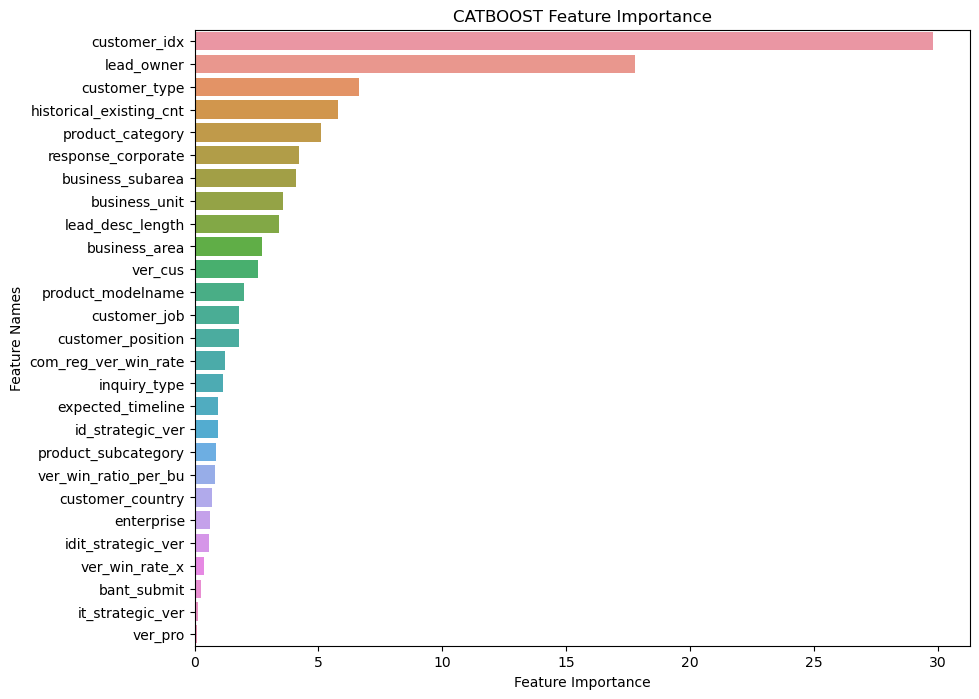

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(best_models[0].get_feature_importance(),df_test.drop(['is_converted','id'],axis=1).columns,'CATBOOST')